<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

# Chiel make the threshold between 0 and 0.2 dor correlation matrixes

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest  # mutual information is a embedded method for regression problems

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [94]:
import pandas as pd

# Import a smaller portion of the data
preproc_train = pd.read_csv('traindf (2).csv').iloc[:1000]  # First 1000 rows and 5 columns
preproc_val = pd.read_csv('valdf (2).csv').iloc[:1000]  # First 500 rows and 5 columns
preproc_test = pd.read_csv('testdf (2).csv').iloc[:1000]  # First 500 rows

In [95]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on the training data
label_encoder.fit(preproc_train['Claim Injury Type'])

# Copy Claim Injury Type as y variable
y = preproc_train['Claim Injury Type'].copy()
y_val = preproc_val['Claim Injury Type'].copy()

# Drop original column from X
X_preproc_train = preproc_train.drop('Claim Injury Type', axis=1)
X_preproc_val = preproc_val.drop('Claim Injury Type', axis=1)


# Transform the 'Claim Injury Type' column in both training and validation sets
preproc_train['Claim Injury Type'] = label_encoder.transform(preproc_train['Claim Injury Type'])
preproc_val['Claim Injury Type'] = label_encoder.transform(preproc_val['Claim Injury Type'])



In [96]:
y_preproc_train = preproc_train['Claim Injury Type']
X_preproc_train = preproc_train.drop(['Claim Injury Type'], axis=1)

y_preproc_val = preproc_val['Claim Injury Type']
X_preproc_val = preproc_val.drop(['Claim Injury Type'], axis=1)

In [97]:
X_preproc_train.shape, X_preproc_val.shape

((1000, 43), (1000, 43))

In [98]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()

# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


In [99]:
# drop Accident Month and Accident Day

X_preproc_train.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
X_preproc_val.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
preproc_test.drop(columns=['Accident Month', 'Accident Day'], inplace=True)

In [100]:
col_fill_median = ['Accident Month Cos', 'Accident Month Sin', 'Accident Day Cos', 'Accident Day Sin']

for col in col_fill_median:
    median_value = X_preproc_train[col].median()

    X_preproc_train[col].fillna(median_value, inplace=True)
    X_preproc_val[col].fillna(median_value, inplace=True)
    preproc_test[col].fillna(median_value, inplace=True)



In [101]:
#check for nan values
X_preproc_train.isna().sum().sort_values()

,0
Assembly Date,0
Above_65,0
Accident Month Sin,0
Accident Month Cos,0
Accident Day Sin,0
Accident Day Cos,0
Received_C2,0
Received_C3,0
Hearing_held,0
Attorney/Representative_Y,0


<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

from this we can tell that, there are no categorical features

In [102]:
X_preproc_train.var().sort_values()

,0
Alternative Dispute Resolution_Y,0.001998
Under_20,0.014790
Received_C2,0.024399
Days_to_Assembly,0.025349
Above_65,0.025349
COVID-19 Indicator_Y,0.037517
high_risk_body,0.040276
Agreement Reached,0.045742
high_risk_cause,0.091688
high_risk_nature,0.113213


No feature to be dropped from this one

<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [103]:
X_preproc_train.head()



,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,-0.067360,1.213328,-0.495974,-0.064860,-1.263841,-0.575548,0.983139,1.274579,1.046863,-0.037533,...,0,0,0,0.610477,0.806579,0.162263,1,0,0,1
1,-0.908646,1.344678,0.955044,-0.783603,0.558209,-0.494377,-0.780636,0.384500,1.046863,-1.477658,...,0,0,0,-0.175047,0.713979,0.277415,0,0,1,1
2,1.012027,-0.755254,-0.133220,0.864313,0.558209,-0.209935,0.983139,1.040655,1.046863,-0.037533,...,0,0,1,-0.025755,0.530618,1.125027,0,0,0,0
3,0.056452,-0.755254,1.317798,0.041721,0.558209,-0.625062,-1.524399,1.040655,1.046863,-0.037533,...,0,0,1,-0.467459,-0.375868,-0.223555,0,0,0,0
4,-0.788009,0.889468,0.156984,-0.698884,-1.896900,-0.453747,-1.524399,0.574898,1.046863,-1.413414,...,0,0,1,0.104639,0.995235,0.774823,0,0,0,0


In [104]:
#drop binary columns
continuous_features = X_preproc_train.drop(columns=['COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'high_risk_nature', 'Received_C2', 'Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'high_risk_body', 'high_risk_cause', 'market_indicator', 'Agreement Reached'])

In [105]:
# round to 1 decimal places
continuous_features = continuous_features.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [106]:

cor_spearman = continuous_features.corr(method ='spearman')
cor_spearman

,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,Age_21_40,Age_41_65,Above_65,Accident Month Sin,Accident Month Cos,Accident Day Sin,Accident Day Cos,wcio_pca1,wcio_pca2,region_cluster
Assembly Date,1.000000,-0.013959,-0.066745,0.977813,0.135701,0.039378,-0.023989,-0.020080,-0.058808,0.389031,...,0.013755,-0.011678,-0.007470,0.204800,0.006417,-0.027944,0.040817,-0.093631,-0.070865,-0.059596
Average Weekly Wage,-0.013959,1.000000,-0.097974,-0.020995,-0.428874,0.132516,-0.056482,0.081562,0.050096,-0.080306,...,-0.096728,0.130316,-0.046109,-0.027021,-0.056585,-0.063087,-0.003328,0.155994,0.054280,0.060970
Birth Year,-0.066745,-0.097974,1.000000,-0.068393,0.048857,0.028700,0.007124,0.013245,-0.042850,-0.002159,...,0.765349,-0.745672,-0.274379,-0.048394,-0.029258,-0.000498,-0.003270,-0.114237,0.063373,-0.043143
C-2 Date,0.977813,-0.020995,-0.068393,1.000000,0.154135,0.039797,-0.007427,-0.036637,-0.081494,0.383803,...,0.012226,-0.010068,0.000163,0.198607,0.014646,-0.020795,0.048585,-0.087701,-0.067654,-0.066259
C-3 Date,0.135701,-0.428874,0.048857,0.154135,1.000000,-0.067166,0.062327,-0.137087,-0.153292,0.163763,...,0.045740,-0.061318,-0.014797,0.004033,0.014664,0.023729,0.024094,-0.035402,-0.099975,-0.058256
Carrier Name,0.039378,0.132516,0.028700,0.039797,-0.067166,1.000000,-0.301669,0.039857,0.051650,0.070975,...,0.013695,0.009356,-0.035149,0.003530,0.015755,0.003729,0.030300,0.052581,0.031883,0.051028
Carrier Type,-0.023989,-0.056482,0.007124,-0.007427,0.062327,-0.301669,1.000000,0.072985,0.065054,0.007146,...,0.032529,-0.046567,0.036932,0.003531,-0.007823,-0.039003,0.011873,-0.064042,-0.040908,0.046748
County of Injury,-0.020080,0.081562,0.013245,-0.036637,-0.137087,0.039857,0.072985,1.000000,0.383700,-0.010045,...,0.007941,0.006830,-0.028873,-0.038734,-0.052840,-0.013637,-0.019881,0.019698,0.042121,0.428780
District Name,-0.058808,0.050096,-0.042850,-0.081494,-0.153292,0.051650,0.065054,0.383700,1.000000,-0.061067,...,-0.045427,0.030940,0.028455,-0.003826,0.024865,0.017378,-0.017918,-0.027133,-0.002854,0.235613
First Hearing Date,0.389031,-0.080306,-0.002159,0.383803,0.163763,0.070975,0.007146,-0.010045,-0.061067,1.000000,...,0.033827,-0.029027,-0.026438,0.078275,-0.025307,0.016759,-0.008255,-0.039821,-0.084382,-0.002521


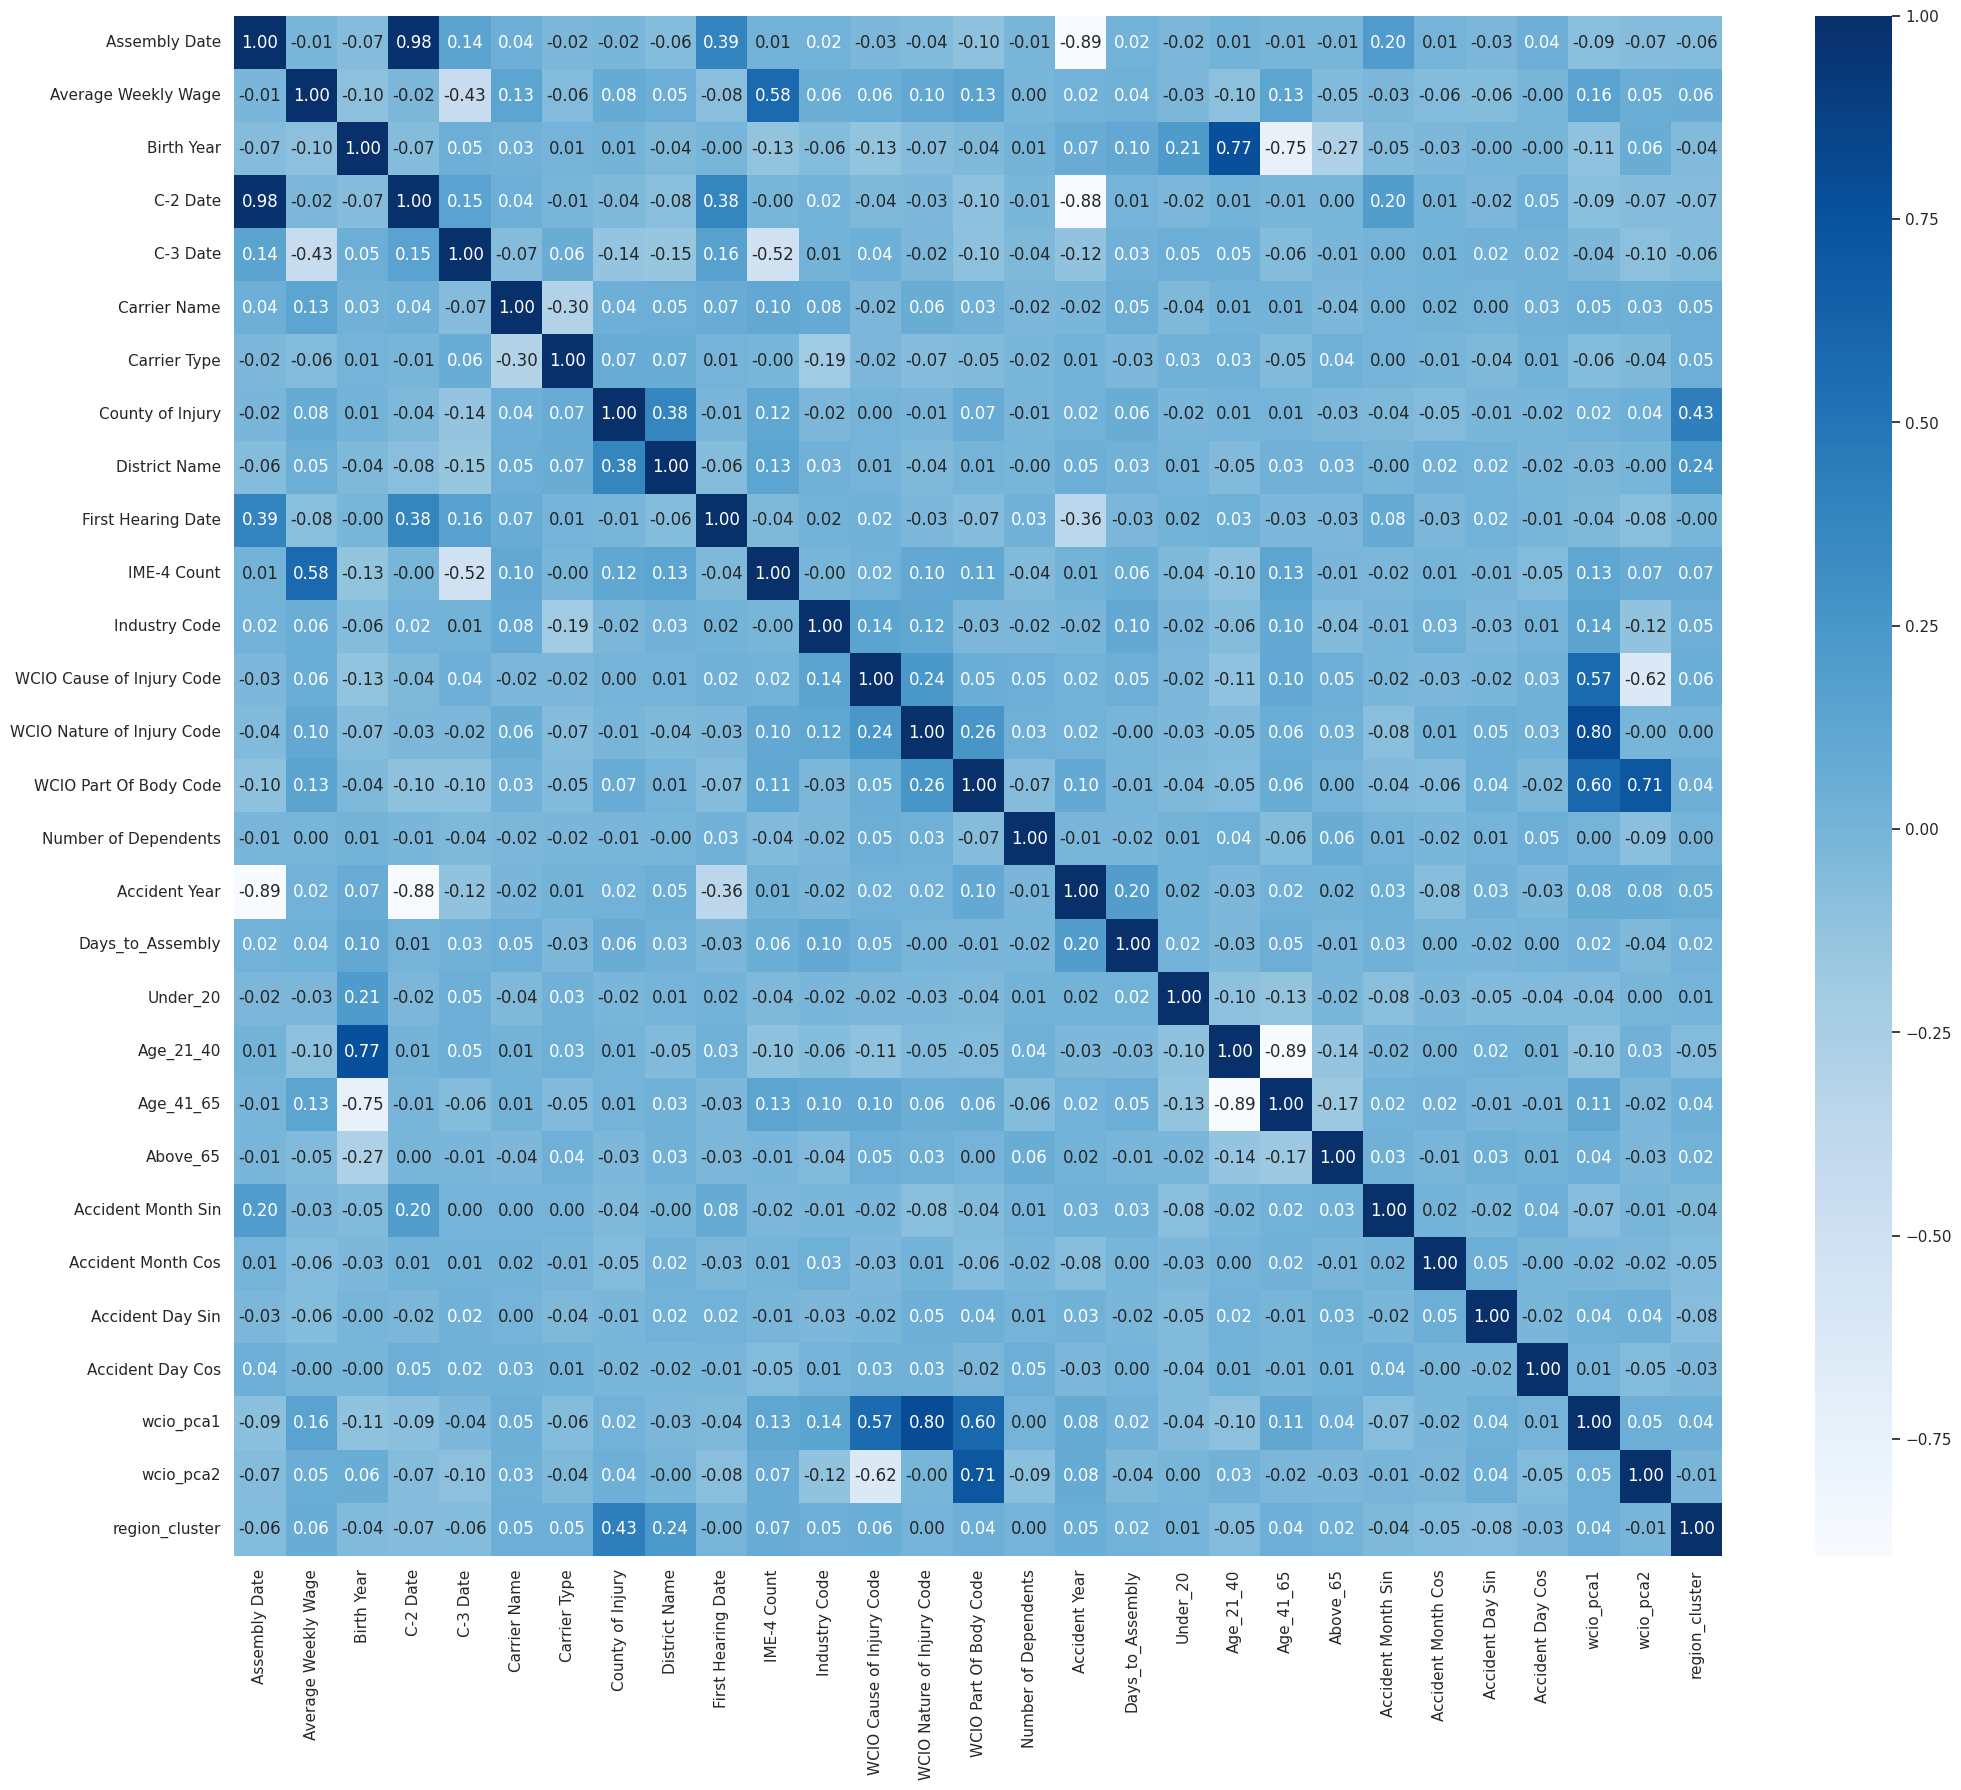

Correlation between Assembly Date and C-2 Date is above 0.8: 0.98
Correlation between C-2 Date and Assembly Date is above 0.8: 0.98


In [107]:
cor_heatmap(cor_spearman)

cor_spearman = continuous_features.corr(method='spearman')

# Filter the correlation matrix
filtered_cor = cor_spearman[
            (cor_spearman > 0.8)
]

# Remove diagonal part
filtered_cor = filtered_cor.mask(np.equal(*np.indices(filtered_cor.shape)))

# Stack the filtered correlation matrix and reset the index
stacked_cor = filtered_cor.stack().reset_index()

# Filter out NaN values and correlations equal to 1
filtered_stacked_cor = stacked_cor[
    stacked_cor[0].notnull() & (stacked_cor[0] != 1)
]

# Print the features and their correlation values with messages
for index, row in filtered_stacked_cor.iterrows():
    feature1 = row['level_0']
    feature2 = row['level_1']
    correlation = row[0]

    if correlation > 0.8:
        print(f"Correlation between {feature1} and {feature2} is above 0.8: {correlation:.2f}")



We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


### Redundancy
drop 'wcio_pca1' or WCIO 'Nature of Injury Code'

drop 'c2 date' or assembly date

drop 'average weekly age or '

### Relevance

Drop Number of depndents




<a class="anchor" id="15th-bullet">

### Mutual Information Classification
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

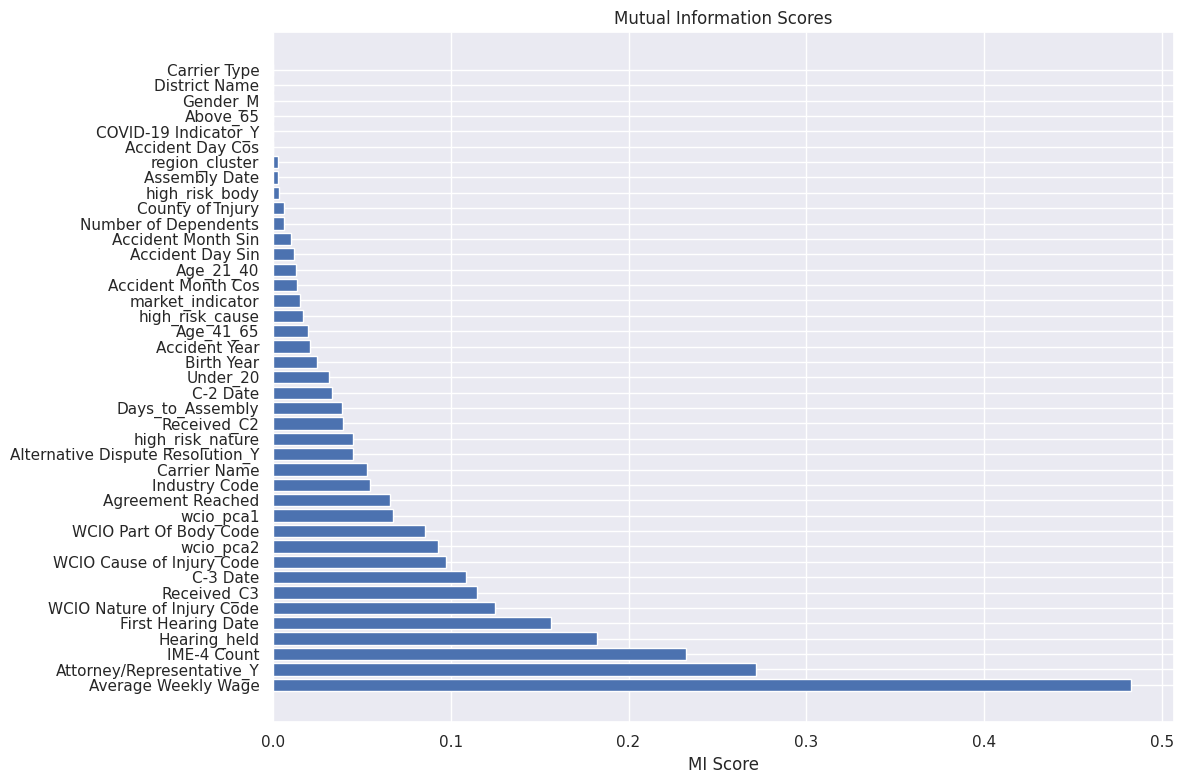


Mutual Information Scores:
--------------------------------------------------
Feature                                  Score
--------------------------------------------------
Average Weekly Wage                     0.4822
Attorney/Representative_Y               0.2716
IME-4 Count                             0.2325
Hearing_held                            0.1825
First Hearing Date                      0.1564
WCIO Nature of Injury Code              0.1248
Received_C3                             0.1147
C-3 Date                                0.1086
WCIO Cause of Injury Code               0.0972
wcio_pca2                               0.0930
WCIO Part Of Body Code                  0.0856
wcio_pca1                               0.0676
Agreement Reached                       0.0660
Industry Code                           0.0547
Carrier Name                            0.0531
Alternative Dispute Resolution_Y        0.0450
high_risk_nature                        0.0450
Received_C2             

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import LabelEncoder
['Claim Injury Type']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

min_size = min(X_preproc_train.shape[0], y_encoded.shape[0])
X_preproc_train = X_preproc_train[:min_size]
y_encoded = y_encoded[:min_size]
mi_scores = mutual_info_classif(X_preproc_train, y_encoded, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({'Feature': X_preproc_train.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
# Create bar plot
plt.figure(figsize=(12, 8))
plt.barh(mi_df['Feature'], mi_df['MI Score'])
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.tight_layout()
plt.show()

# Print formatted table
print("\nMutual Information Scores:")
print("-" * 50)
print(f"{'Feature':<35} {'Score':>10}")
print("-" * 50)
for _, row in mi_df.iterrows():
   print(f"{row['Feature']:<35} {row['MI Score']:>10.4f}")

   
Dropping the ones with a zero score:     >>>>>>>>>                                ^^^^^^^


#VIF


Strict threshold (5):
Features to drop: 8
Features: ['Age_41_65', 'Age_21_40', 'market_indicator', 'Assembly Date', 'high_risk_nature', 'C-2 Date', 'Received_C3', 'C-3 Date']

Moderate threshold (10):
Features to drop: 3
Features: ['Age_41_65', 'Age_21_40', 'market_indicator']

Lenient threshold (20):
Features to drop: 1
Features: ['Age_41_65']


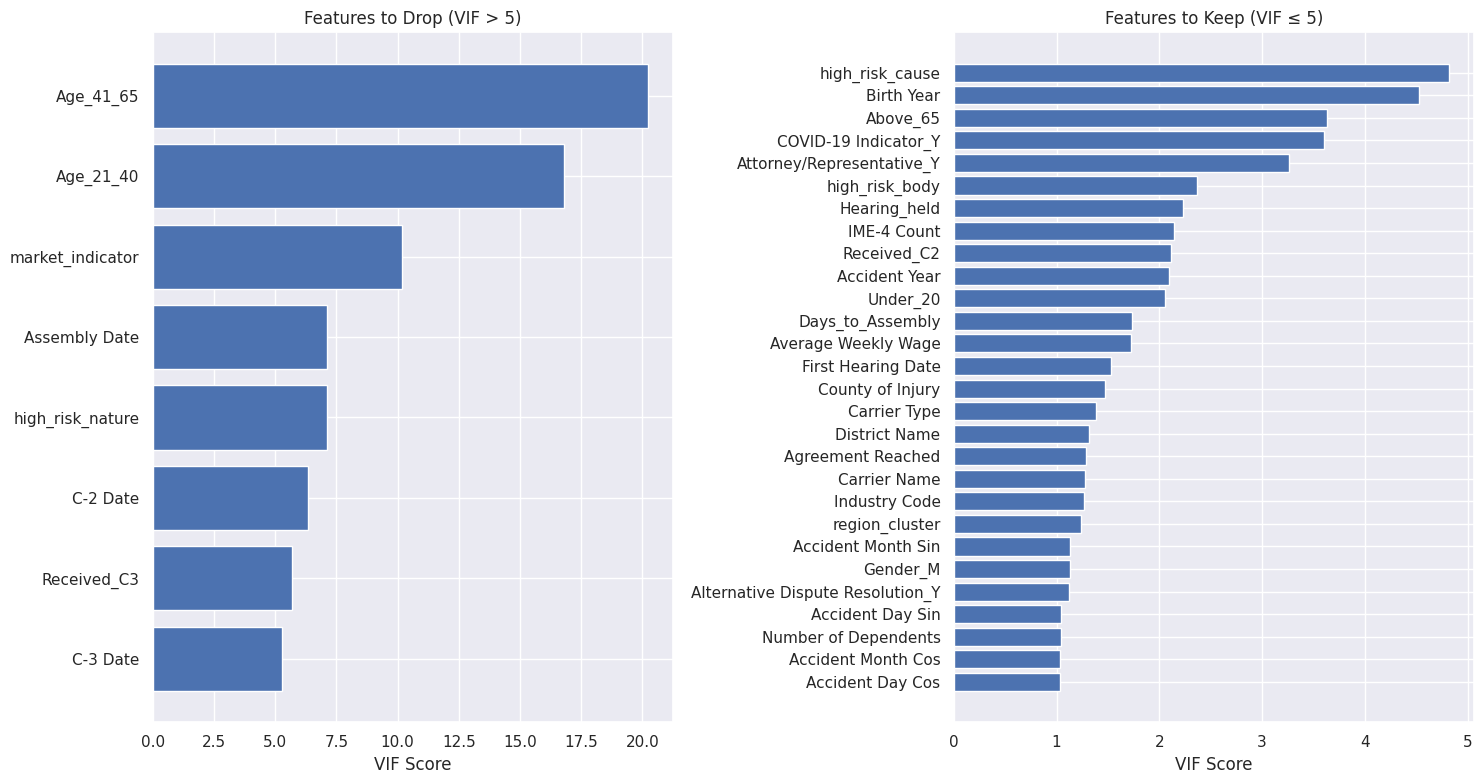

In [109]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_vif(X):
   vif_data = pd.DataFrame()
   vif_data["Feature"] = X.columns
   vif_data["VIF"] = [_calculate_vif(X, i) for i in range(X.shape[1])]
   return vif_data.sort_values('VIF', ascending=False)

def _calculate_vif(X, i):
   y = X.iloc[:, i]
   X_other = X.drop(X.columns[i], axis=1)
   model = LinearRegression()
   model.fit(X_other, y)
   r_squared = model.score(X_other, y)
   if r_squared == 1:
       return float('inf')
   return 1 / (1 - r_squared)

# Calculate VIF
vif_df = calculate_vif(X_preproc_train)

# Common thresholds
vif_thresholds = {
    'strict': 5,    # Remove VIF > 5
    'moderate': 10, # Remove VIF > 10
    'lenient': 20   # Remove VIF > 20
}

# Get features to drop
def get_vif_features(vif_df, threshold):
    return vif_df[vif_df['VIF'] > threshold]['Feature'].tolist()

# Remove infinite VIFs first
features_to_drop = vif_df[vif_df['VIF'].isin([float('inf')])]['Feature'].tolist()

# Print features to drop at each threshold
for name, threshold in vif_thresholds.items():
    features = get_vif_features(vif_df[vif_df['VIF'] != float('inf')], threshold)
    print(f"\n{name.title()} threshold ({threshold}):")
    print(f"Features to drop: {len(features)}")
    print(f"Features: {features}")

# Get all features with finite VIF scores, sorted
vif_df_finite = vif_df[vif_df['VIF'] != float('inf')].sort_values('VIF', ascending=True)

# Features to drop (VIF > 5)
features_to_drop = get_vif_features(vif_df_finite, 5)

# Features to keep (VIF <= 5)
features_to_keep = vif_df_finite[vif_df_finite['VIF'] <= 5]['Feature'].tolist()

# Save both lists to CSV
pd.DataFrame({
   'features_to_drop': pd.Series(features_to_drop),
   'features_to_keep': pd.Series(features_to_keep)
}).to_csv('fs1.csv', index=False)

import matplotlib.pyplot as plt

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot features to drop
vif_drop = vif_df_finite[vif_df_finite['VIF'] > 5]
ax1.barh(vif_drop['Feature'], vif_drop['VIF'])
ax1.set_title('Features to Drop (VIF > 5)')
ax1.set_xlabel('VIF Score')

# Plot features to keep
vif_keep = vif_df_finite[vif_df_finite['VIF'] <= 5]
ax2.barh(vif_keep['Feature'], vif_keep['VIF'])
ax2.set_title('Features to Keep (VIF ≤ 5)')
ax2.set_xlabel('VIF Score')

plt.tight_layout()
plt.show()

In [110]:
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.impute import SimpleImputer

# # Using imputed data
# mic = SelectKBest(score_func=mutual_info_classif, k='all')
# mic.fit(X_imputed, y_preproc_train)

# mic_scores = pd.Series(mic.scores_, index=X_imputed.columns)
# plot_importance(mic_scores, 'Mutual Information')
# eliminated_features = mic_scores[mic_scores <= 0.0243].index
# print(f"Features to be eliminated:\n{eliminated_features}")

<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

In [111]:
#how many na values are in the dataset
y_preproc_train.isna()

,Claim Injury Type
0,False
1,False
2,False
3,False
4,False
...,...
995,False
996,False
997,False
998,False


<a class="anchor" id="13th-bullet">

#### RFE XGBoosting

</a>

Using RFE, the objective is finding the optimal number of features to select

### RFE XGBoosting

In [112]:
# #number of features
# nof_list= np.arange(1, 41)
# high_score=0

# #Variable to store the optimum features
# nof=0
# train_f1score_list =[]
# val_f1score_list = []

# for n in range(len(nof_list)):

#     #using XGBoost
#     model = XGBClassifier(objective='multi:softprob',
#                           random_state=42,
#                           learning_rate=0.075,
#                           max_depth=12,
#                           min_child_weight=8,
#                           subsample=0.8,
#                           colsample_bytree=0.6,
#                           n_estimators=2000,
#                           reg_alpha=1.0,
#                             reg_lambda=1.5
# )

#     rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
#     X_train_rfe = rfe.fit_transform(X_preproc_train[:500],y_preproc_train[:500])
#     X_val_rfe = rfe.transform(X_preproc_val[:500])

#     model.fit(X_train_rfe[:500],y_preproc_train[:500])

#     # Predictions for F1 score
#     y_preproc_train_pred = model.predict(X_train_rfe)
#     y_preproc_val_pred = model.predict(X_val_rfe)

#     #storing results on training data
#     train_f1score = f1_score(y_preproc_train[:500],y_preproc_train_pred[:500], average='macro')
#     train_f1score_list.append(train_f1score)

#     #storing results on training data
#     val_f1score = f1_score(y_preproc_val[:500],y_preproc_val_pred[:500], average='macro')
#     val_f1score_list.append(val_f1score)

#     #check best score
#     if(val_f1score >= high_score):
#         high_score = val_f1score
#         nof = nof_list[n]
#         features_to_select = pd.Series(rfe.support_, index = X_preproc_train.columns)


# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))
# print(f"Features to select: \n{features_to_select}")


In [113]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

nof_list = np.arange(1, 41)
high_score = 0
nof = 0
scores = {}

# Get feature importances from base model
model = XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        learning_rate=0.05046195857265063,
        max_depth=14,
        min_child_weight=4.295663382738008,
        subsample=0.5794673021390964,
        colsample_bytree=0.6752893520492427,
        n_estimators=716,
        reg_alpha=0.2207882375290882,
        reg_lambda=0.28791727579162424,
        gamma=1.5556906330098323,
    )

model.fit(X_preproc_train, y_preproc_train)
importances = pd.Series(model.feature_importances_, index=X_preproc_train.columns)
sorted_features = importances.sort_values(ascending=False)

# Try different numbers of top features
for n in nof_list:
    selected_features = sorted_features.head(n).index
    X_train_selected = X_preproc_train[selected_features]
    X_val_selected = X_preproc_val[selected_features]

    model.fit(X_train_selected, y_preproc_train)
    val_pred = model.predict(X_val_selected)
    score = f1_score(y_preproc_val, val_pred, average='macro')
    scores[n] = score

    if score > high_score:
        high_score = score
        nof = n

best_features = sorted_features.head(nof).index
print(f"Optimal features: {nof}")
print(f"Best score: {high_score:.4f}")
print(f"Selected features:\n{best_features}")

Optimal features: 16
Best score: 0.5022
Selected features:
Index(['Average Weekly Wage', 'Attorney/Representative_Y', 'Agreement Reached',
       'Hearing_held', 'IME-4 Count', 'Received_C2', 'Days_to_Assembly',
       'C-3 Date', 'Age_21_40', 'high_risk_cause',
       'WCIO Nature of Injury Code', 'Age_41_65', 'WCIO Part Of Body Code',
       'wcio_pca1', 'market_indicator', 'First Hearing Date'],
      dtype='object')


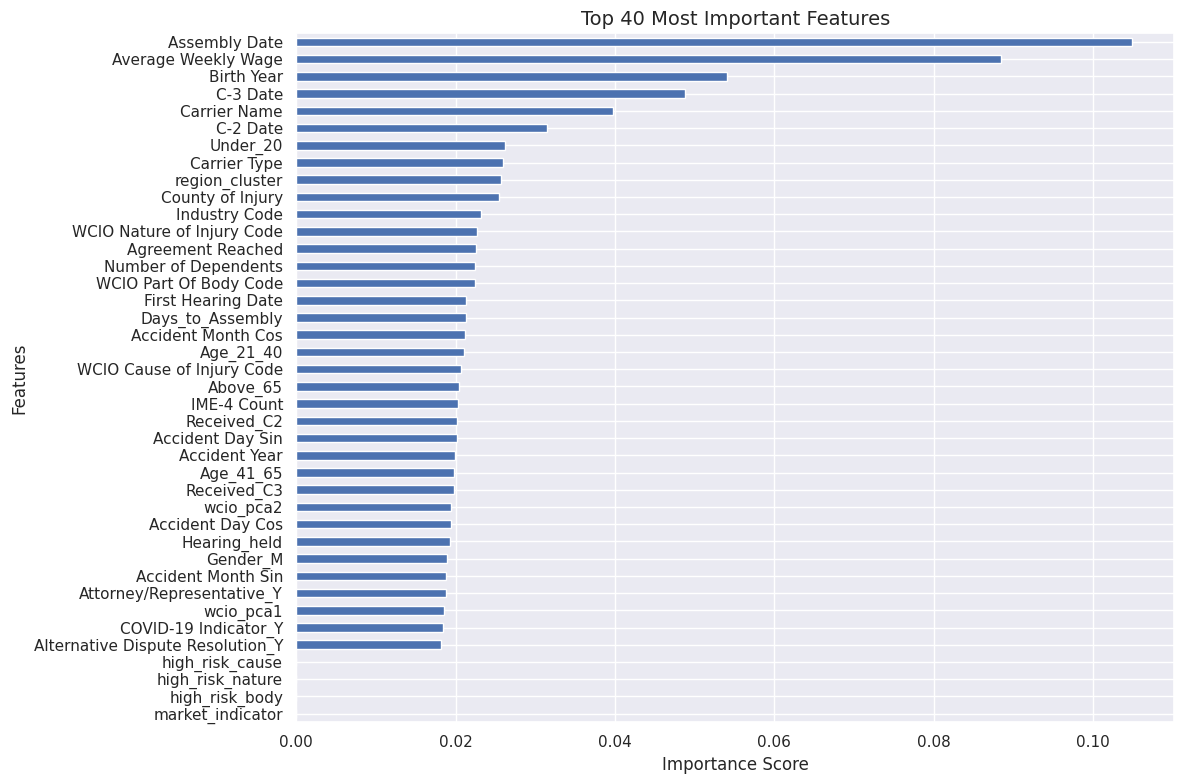


Feature Importance Ranking:
--------------------------------------------------
Feature                                  Score
--------------------------------------------------
Assembly Date                           0.1049
Average Weekly Wage                     0.0884
Birth Year                              0.0540
C-3 Date                                0.0488
Carrier Name                            0.0398
C-2 Date                                0.0315
Under_20                                0.0262
Carrier Type                            0.0259
region_cluster                          0.0258
County of Injury                        0.0255
Industry Code                           0.0232
WCIO Nature of Injury Code              0.0227
Agreement Reached                       0.0226
Number of Dependents                    0.0224
WCIO Part Of Body Code                  0.0224
First Hearing Date                      0.0213
Days_to_Assembly                        0.0213
Accident Month Cos     

In [114]:
# Drop extra feature
X_preproc_train = X_preproc_train.drop('District Name', axis=1)
X_preproc_val = X_preproc_val.drop('District Name', axis=1)

importances = pd.Series(model.feature_importances_, index=X_preproc_train.columns)

plt.figure(figsize=(12, 8))
importances.sort_values(ascending=True).tail(40).plot(kind='barh')
plt.title('Top 40 Most Important Features', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Print table
print("\nFeature Importance Ranking:")
print("-" * 50)
print(f"{'Feature':<35} {'Score':>10}")
print("-" * 50)
for feature, score in importances.sort_values(ascending=False).items():
    print(f"{feature:<35} {score:>10.4f}")

In [115]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt



def compute_importance_scores(model, X, y, n_repeats=10):
   result = permutation_importance(
       model, X, y,
       n_repeats=n_repeats,
       random_state=42,
       n_jobs=-1
   )

   importances = pd.DataFrame(
       {'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std}
   )
   return importances.sort_values('Importance', ascending=False)

# Calculate importance
ig_scores = compute_importance_scores(model, X_preproc_train, y)

# Plot
plt.figure(figsize=(12, 8))
plt.errorbar(
   ig_scores['Importance'],
   np.arange(len(ig_scores)),
   xerr=ig_scores['Std'],
   fmt='o'
)
plt.yticks(np.arange(len(ig_scores)), ig_scores['Feature'])
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

# Save results
ig_scores.to_csv('ig_scores.csv', index=False)

ValueError: feature_names mismatch: ['Average Weekly Wage', 'Attorney/Representative_Y', 'Agreement Reached', 'Hearing_held', 'IME-4 Count', 'Received_C2', 'Days_to_Assembly', 'C-3 Date', 'Age_21_40', 'high_risk_cause', 'WCIO Nature of Injury Code', 'Age_41_65', 'WCIO Part Of Body Code', 'wcio_pca1', 'market_indicator', 'First Hearing Date', 'C-2 Date', 'Assembly Date', 'Received_C3', 'Carrier Name', 'District Name', 'wcio_pca2', 'WCIO Cause of Injury Code', 'Number of Dependents', 'Accident Day Cos', 'Accident Day Sin', 'County of Injury', 'region_cluster', 'Industry Code', 'Birth Year', 'Gender_M', 'Carrier Type', 'Accident Year', 'Accident Month Cos', 'Accident Month Sin', 'high_risk_nature', 'high_risk_body', 'Alternative Dispute Resolution_Y', 'Above_65', 'COVID-19 Indicator_Y'] ['Assembly Date', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'First Hearing Date', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents', 'Accident Year', 'Days_to_Assembly', 'Under_20', 'Age_21_40', 'Age_41_65', 'Above_65', 'Accident Month Sin', 'Accident Month Cos', 'Accident Day Sin', 'Accident Day Cos', 'Received_C2', 'Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'wcio_pca1', 'wcio_pca2', 'region_cluster', 'high_risk_nature', 'high_risk_body', 'high_risk_cause', 'market_indicator']
expected District Name in input data
training data did not have the following fields: Under_20

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_preproc_train), columns=X_preproc_train.columns)

# Fit LogisticRegressionCV
reg = LogisticRegressionCV(cv=10, penalty='l1', solver='saga', random_state=42)
reg.fit(X_imputed, y_preproc_train)

# Get coefficients
coef = pd.Series(reg.coef_[0], index=X_imputed.columns)

# Plot feature importance
plt.figure(figsize=(12, 8))
coef.sort_values().plot(kind='barh')
plt.title('Feature Importance using Lasso Model')
plt.tight_layout()
plt.show()

print(f"Features selected: {sum(coef != 0)}")
print(f"Features eliminated: {sum(coef == 0)}")

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
#print the features that were eliminated

features_eliminated = coef[coef == 0]
print(f"Features eliminated: \n{features_eliminated.sort_values()}")

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

### Numerical Data

| Predictor | Unvariate|  Spearman | Variance information factor (VIF)| (IG)Information Gain | Feature Imprtance XGB (SHAP)| RFE XGB | Lasso | Mutual Information Class. | What to do? |
| --- | --- | --- | --- |--- |---|---|---|---| ---|
| Age at Injury | Keep | --- | --- |--- |---|---|---|---| ---|
| Assembly Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Average Weekly Wage | Keep | --- | --- |--- |---|---|---|---| ---|
| Birth Year | Keep | --- | --- |--- |---|---|---|---| ---|
| C-2 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| C-3 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Name | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Type | Keep | --- | --- |--- |---|---|---|---| ---|
| County of Injury | Keep | --- | --- |--- |---|---|---|---| ---|
10| District Name | Keep | --- | --- |--- |---|---|---|---| ---|
| First Hearing Date | Keep | --- | --- |--- |---|---|---|---| ---|
| IME-4 Count | Keep | --- | --- |--- |---|---|---|---| ---|
| Industry Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Medical Fee Region | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Cause of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Nature of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Part Of Body Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Zip Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Agreement Reached | Keep | --- | --- |--- |---|---|---|---| ---|
20| Number of Dependents | Keep | --- | --- |--- |---|---|---|---| ---|
| Accident Year | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C2 | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C3 | Keep | --- | --- |--- |---|---|---|---| ---|
| Hearing_held | Keep | --- | --- |--- |---|---|---|---| ---|
| Attorney/Representative_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| COVID-19 Indicator_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Alternative Dispute Resolution_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Gender_M | Keep | --- | --- |--- |---|---|---|---| ---|
| wcio_pca1 | Keep | --- | --- |--- |---|---|---|---| ---|
30| wcio_pca2 | Keep | --- | --- |--- |---|---|---|---| ---|
| region_cluster | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_nature | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_body | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_cause | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
40| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
<hr>


